# COGS 108 - EDA Checkpoint

# Names

- Gavin Zhao
- Simon Zheng
- Tunan Li
- Yufei Zhang

<a id='research_question'></a>
# Research Question

How do domestic economic differences contribute to the migration of American citizens among different states? Specifically, how do in-state median salaries, Gross Domestic Product, and housing prices relate to changes in populations in different states in the US from 2010 to 2019? If so, are there any significant trends we can observe?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import patsy
import statsmodels.api as sm
import datetime

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data

**Dataset1 - US Migration Flow in 10 Years**
- Dataset Name: Migration_Flows_from_2010_to_2019.csv
- Link to the dataset: https://www.kaggle.com/datasets/finnegannguyen/statetostate-migration-flows-from-2010-to-2019
- Number of observations: 16,848
- Description: This is the main dataset of the population, including precisely quantized migration flows in the United States from 2010 to 2019 with adequate sample size (the number of states being evaluated). The source is from the US Census, which can be found on the American Community Survey website: https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html. According to US Census, the sample variability can lead to roughly 90% of margin of error, in addition to some potential nonsampling error.
The data set includes the following variables:
1. Current state that people reside in the year of the measurement
2. Years studied
3. The population of the current state in the year of the measurement
4. Residents number remaining in the same house as the previous year
5. Residents number remaining in the same state as the previous year
6. Number of people migrate to the current state from different states (in total)
7. Number of people from abroad migrate to the current state
8. Original place from where people migrate to the current state
9. Number of people from other states  migrate to the current state
<br>
<br>

**Dataset2 - Median Household Income**

- Dataset Name: Median household income, by state: Selected years, 1990 through 2019
- Link to the dataset: https://nces.ed.gov/programs/digest/d20/tables/dt20_102.30.asp
- Number of observations: 520

This dataset includes 520 observations of Median annual household income by state from 1990-2019. We will combine this dataset to data1 mentioned above based on corresponding state and year. This data would help us answer the question how median household income influence the migration between states.

<br>
<br>

**Dataset 3 - US GDP by State 1997-2020**
- Dataset Name: US GDP by State 1997 - 2020 (How much does each state produce?)
- Link: https://www.kaggle.com/datasets/davidbroberts/us-gdp-by-state-19972020
- Number of observations: 143702 
- Description: This dataset contains the official dataset from Bureau Of Economic Analysis about individual US state GDP as well as the overall US GDP from 1997 to 2020. The data includes information on the specific GDP break downs for different states, including GDP of industries such as agriculture, mining, oil, etc. 
<br>
<br>


**Dataset4 - Average Housing Price**

- Dataset Name: Average housing price - economic research
- Link to the dataset: https://fred.stlouisfed.org/searchresults?st=housing+price&pageID=2
- Number of observations: 16,520
- Description: In each of the data links of states, there are about 280 rows of housing prices of the specific state from 1963 to 2022. The two columns are the time (by quarter), and the housing price index. We will definitely merge the numerous data tables above (each representing a unique state) into one CSV file that contains all information on manipulating the price index, and eventually, find the relationship between housing prices and migration flow. The states of interest (the states that will be included in the main table) will be selected based on the result of the analysis of GDP and average salary. For example, if California has a high flow of incoming people with a strong relation with trends of GDP and average salary in that state, we look back to the California housing price index and analyze if it plays a crucial role.

# Data Cleaning

### For Dataset 1-US migration flow in 10 years, we will be...

*  Removing unnecessary columns and rows
*  Renaming column name for clarification
*  Dropping null values in the table

Firstly importing the datasets:

In [2]:
US_migration = pd.read_csv("Migration_Flows_from_2010_to_2019.csv")
US_migration

,current_state,year,population,same_house,same_state,from_different_state_Total,abroad_Total,from,number_of_people
0,Alabama,2010,4729509,3987155,620465,108723,13166,Alabama,0
1,Alaska,2010,702974,565031,95878,36326,5739,Alabama,477
2,Arizona,2010,6332786,5069002,1001991,222725,39068,Alabama,416
3,Arkansas,2010,2888304,2387806,412997,79127,8374,Alabama,1405
4,California,2010,36907897,30790221,5413287,444749,259640,Alabama,3364
...,...,...,...,...,...,...,...,...,...
28075,Washington,2019,7527366,6253469,977928,231956,64013,abroad_ForeignCountry,62230
28076,West Virginia,2019,1773280,1563611,164739,39548,5382,abroad_ForeignCountry,4776
28077,Wisconsin,2019,5760481,5001140,634732,107973,16636,abroad_ForeignCountry,16123
28078,Wyoming,2019,572884,473128,68127,30247,1382,abroad_ForeignCountry,1382


Removing unnecessary columns:
- Specifically, we removed the number of people migrated to the current state from abroad and the number of residents remaining in the same house, because we only limit our study in the US domestically, and we don't look into details of how people changed housing within the state.

In [3]:
col_names = []
for col in US_migration:
    col_names.append(col)
print(col_names)

['current_state', 'year', 'population', 'same_house', 'same_state', 'from_different_state_Total', 'abroad_Total', 'from', 'number_of_people']


In [4]:
# removed the column "abroad_Total" and "same_house"
US_migration = US_migration[['current_state', 'year', 'population', 'same_state', 'from_different_state_Total', 'from', 'number_of_people']]
US_migration

,current_state,year,population,same_state,from_different_state_Total,from,number_of_people
0,Alabama,2010,4729509,620465,108723,Alabama,0
1,Alaska,2010,702974,95878,36326,Alabama,477
2,Arizona,2010,6332786,1001991,222725,Alabama,416
3,Arkansas,2010,2888304,412997,79127,Alabama,1405
4,California,2010,36907897,5413287,444749,Alabama,3364
...,...,...,...,...,...,...,...
28075,Washington,2019,7527366,977928,231956,abroad_ForeignCountry,62230
28076,West Virginia,2019,1773280,164739,39548,abroad_ForeignCountry,4776
28077,Wisconsin,2019,5760481,634732,107973,abroad_ForeignCountry,16123
28078,Wyoming,2019,572884,68127,30247,abroad_ForeignCountry,1382


Removing unnecessary rows:
For the same reason, by putting constraint on the "from" column, remove the rows in which it records people migrated to the current states from foreign country.

In [5]:
US_migration = US_migration.loc[US_migration['from'] != 'abroad_ForeignCountry']

Then, we rename the column names for clarification:

In [6]:
US_migration.rename(columns={'from':'migrated_from'}, inplace=True)
US_migration.rename(columns={'number_of_people':'number_from_given_state'}, inplace=True)
US_migration.head()

/tmp/ipykernel_494/2776812262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_migration.rename(columns={'from':'migrated_from'}, inplace=True)
/tmp/ipykernel_494/2776812262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_migration.rename(columns={'number_of_people':'number_from_given_state'}, inplace=True)


,current_state,year,population,same_state,from_different_state_Total,migrated_from,number_from_given_state
0,Alabama,2010,4729509,620465,108723,Alabama,0
1,Alaska,2010,702974,95878,36326,Alabama,477
2,Arizona,2010,6332786,1001991,222725,Alabama,416
3,Arkansas,2010,2888304,412997,79127,Alabama,1405
4,California,2010,36907897,5413287,444749,Alabama,3364


Lastly, check if there is any potential null value from the table 
- According to the result below, there is no null value, so we don't need to worry about it.

In [7]:
US_migration.isna().any()
US_migration.isnull().sum().sum()

0

### For Dataset 2, we will be...

*  Removing unnecessary columns and rows
*  Selecting obersvations from 2010-2019
*  Renaming column name for clarification
*  Dropping null values


Importing Datasets:

In [8]:
US_GDP = pd.read_csv('US_GDP_by State_1997_to_2020.csv', skipinitialspace=True)
Household_income = pd.read_csv('Household_income.csv')
US_GDP
Household_income.head()

,column_index,column_level,column_level_1,column_level_1_ref_note,digest_table_sub_id,is_total,location,location_type,row_index,row_level,row_level_1,value,year,deflator,row_level_2,standard_error
0,A,1990,1990,Based on 1989 incomes collected in the 1990 ce...,A,True,United States,country,1,United States,United States,60000,1990,Consumer Price Index Research Series Using Cur...,NaN,NaN
1,A,1990,1990,Based on 1989 incomes collected in the 1990 ce...,A,False,Alabama,State,2,United States:::Alabama,United States,47100,1990,Consumer Price Index Research Series Using Cur...,Alabama,NaN
2,A,1990,1990,Based on 1989 incomes collected in the 1990 ce...,A,False,Alaska,State,3,United States:::Alaska,United States,82700,1990,Consumer Price Index Research Series Using Cur...,Alaska,NaN
3,A,1990,1990,Based on 1989 incomes collected in the 1990 ce...,A,False,Arizona,State,4,United States:::Arizona,United States,55000,1990,Consumer Price Index Research Series Using Cur...,Arizona,NaN
4,A,1990,1990,Based on 1989 incomes collected in the 1990 ce...,A,False,Arkansas,State,5,United States:::Arkansas,United States,42200,1990,Consumer Price Index Research Series Using Cur...,Arkansas,NaN


#### Selecting observations, removing columns and rows

In [9]:
Household_income=Household_income.loc[Household_income['year']>=2010]
Household_income=Household_income.loc[Household_income['location']!='United States']
Household_income=Household_income.reset_index()
Household_income=Household_income[['location','value','year']]
Household_income

,location,value,year
0,Alabama,47600,2010
1,Alaska,75900,2010
2,Arizona,55000,2010
3,Arkansas,45000,2010
4,California,67800,2010
...,...,...,...
352,Virginia,76500,2019
353,Washington,78700,2019
354,West Virginia,48900,2019
355,Wisconsin,64200,2019


Renaming column name for clarification

In [10]:
Household_income.rename(columns={'value':'median_hhi'}, inplace=True)
Household_income.rename(columns={'location':'state'}, inplace=True)
Household_income

,state,median_hhi,year
0,Alabama,47600,2010
1,Alaska,75900,2010
2,Arizona,55000,2010
3,Arkansas,45000,2010
4,California,67800,2010
...,...,...,...
352,Virginia,76500,2019
353,Washington,78700,2019
354,West Virginia,48900,2019
355,Wisconsin,64200,2019


#### Dropping null values

In [11]:
Household_income.dropna()

,state,median_hhi,year
0,Alabama,47600,2010
1,Alaska,75900,2010
2,Arizona,55000,2010
3,Arkansas,45000,2010
4,California,67800,2010
...,...,...,...
352,Virginia,76500,2019
353,Washington,78700,2019
354,West Virginia,48900,2019
355,Wisconsin,64200,2019


### For Dataset 3, we will be...

*  Removing unnecessary columns
*  Renaming some columns
*  Examining and converting GDP values to floats
*  Dropping null values


#### Removing columns

In [12]:
column_names = []
for col in US_GDP.columns:
    column_names.append(col)
print(column_names)

['GeoFIPS', 'GeoName', 'Region', 'TableName', 'LineCode', 'IndustryClassification', 'Description', 'Unit', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


In [13]:
US_GDP = US_GDP[['GeoName', 'Description', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']]
US_GDP

,GeoName,Description,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United States *,All industry total,8577552.0,9062817.0,9630663.0,10252347.0,10581822.0,10936418.0,11458246.0,12213730.0,...,15542582.0,16197007.0,16784851.0,17527258.0,18238301.0,18745075.0,19542980.0,20611861.0,21433226.0,20936558.0
1,United States *,Private industries,7431992.0,7871500.0,8378315.0,8929320.0,9188887.0,9462020.0,9905899.0,10582459.0,...,13405520.0,14037519.0,14572341.0,15255889.0,15898859.0,16360179.0,17094245.0,18062184.0,18793750.0,18290860.0
2,United States *,"Agriculture, forestry, fishing and hunting",108637.0,99756.0,92590.0,98312.0,99836.0,95629.0,113953.0,142945.0,...,180945.0,179573.0,215601.0,201003.0,182283.0,166571.0,176625.0,178569.0,175373.0,175802.0
3,United States *,Farms,88136.0,79030.0,70934.0,76043.0,78093.0,74033.0,91105.0,119356.0,...,152249.0,148939.0,184621.0,168147.0,147384.0,130639.0,140053.0,140271.0,136080.0,(NA)
4,United States *,"Forestry, fishing, and related activities",20501.0,20726.0,21656.0,22269.0,21743.0,21596.0,22848.0,23589.0,...,28696.0,30634.0,30980.0,32856.0,34899.0,35932.0,36571.0,38298.0,39293.0,(NA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5523,Far West,Private services-providing industries 3/,985596.4,1064211.3,1160608.6,1244783.3,1289426.5,1358322.0,1432417.9,1523846.3,...,1976062.0,2075109.3,2181136.7,2313170.7,2486666.3,2618453.8,2789660.2,2954243.6,3138895.7,3104513.5
5524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Renaming columns

In [14]:
US_GDP.rename(columns={'Description':'Industry'}, inplace=True)
US_GDP.head()

,GeoName,Industry,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United States *,All industry total,8577552.0,9062817.0,9630663.0,10252347.0,10581822.0,10936418.0,11458246.0,12213730.0,...,15542582.0,16197007.0,16784851.0,17527258.0,18238301.0,18745075.0,19542980.0,20611861.0,21433226.0,20936558.0
1,United States *,Private industries,7431992.0,7871500.0,8378315.0,8929320.0,9188887.0,9462020.0,9905899.0,10582459.0,...,13405520.0,14037519.0,14572341.0,15255889.0,15898859.0,16360179.0,17094245.0,18062184.0,18793750.0,18290860.0
2,United States *,"Agriculture, forestry, fishing and hunting",108637.0,99756.0,92590.0,98312.0,99836.0,95629.0,113953.0,142945.0,...,180945.0,179573.0,215601.0,201003.0,182283.0,166571.0,176625.0,178569.0,175373.0,175802.0
3,United States *,Farms,88136.0,79030.0,70934.0,76043.0,78093.0,74033.0,91105.0,119356.0,...,152249.0,148939.0,184621.0,168147.0,147384.0,130639.0,140053.0,140271.0,136080.0,(NA)
4,United States *,"Forestry, fishing, and related activities",20501.0,20726.0,21656.0,22269.0,21743.0,21596.0,22848.0,23589.0,...,28696.0,30634.0,30980.0,32856.0,34899.0,35932.0,36571.0,38298.0,39293.0,(NA)


#### Converting GDP values to floats

In [15]:
US_GDP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5528 entries, 0 to 5527
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GeoName   5524 non-null   object 
 1   Industry  5524 non-null   object 
 2   1997      5524 non-null   object 
 3   1998      5524 non-null   object 
 4   1999      5524 non-null   object 
 5   2000      5524 non-null   object 
 6   2001      5524 non-null   object 
 7   2002      5524 non-null   object 
 8   2003      5524 non-null   object 
 9   2004      5524 non-null   object 
 10  2005      5524 non-null   object 
 11  2006      5524 non-null   object 
 12  2007      5524 non-null   object 
 13  2008      5524 non-null   object 
 14  2009      5524 non-null   object 
 15  2010      5524 non-null   object 
 16  2011      5524 non-null   object 
 17  2012      5524 non-null   object 
 18  2013      5524 non-null   object 
 19  2014      5524 non-null   object 
 20  2015      5524 non-null   obje

In [16]:
years = ['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
US_GDP[years] = US_GDP[years].apply(pd.to_numeric, errors='coerce', axis=1)
US_GDP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5528 entries, 0 to 5527
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GeoName   5524 non-null   object 
 1   Industry  5524 non-null   object 
 2   1997      5522 non-null   float64
 3   1998      5521 non-null   float64
 4   1999      5521 non-null   float64
 5   2000      5521 non-null   float64
 6   2001      5520 non-null   float64
 7   2002      5522 non-null   float64
 8   2003      5522 non-null   float64
 9   2004      5522 non-null   float64
 10  2005      5521 non-null   float64
 11  2006      5521 non-null   float64
 12  2007      5521 non-null   float64
 13  2008      5521 non-null   float64
 14  2009      5520 non-null   float64
 15  2010      5521 non-null   float64
 16  2011      5520 non-null   float64
 17  2012      5522 non-null   float64
 18  2013      5523 non-null   float64
 19  2014      5523 non-null   float64
 20  2015      5523 non-null   floa

#### Dropping null values

In [17]:
US_GDP.isna().any()

GeoName     True
Industry    True
1997        True
1998        True
1999        True
2000        True
2001        True
2002        True
2003        True
2004        True
2005        True
2006        True
2007        True
2008        True
2009        True
2010        True
2011        True
2012        True
2013        True
2014        True
2015        True
2016        True
2017        True
2018        True
2019        True
2020        True
dtype: bool

We only want to drop the last few rows whose GeoName contains null values and retain all other rows.

In [18]:
US_GDP = US_GDP[US_GDP['GeoName'].notna()]
US_GDP.head()

,GeoName,Industry,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United States *,All industry total,8577552.0,9062817.0,9630663.0,10252347.0,10581822.0,10936418.0,11458246.0,12213730.0,...,15542582.0,16197007.0,16784851.0,17527258.0,18238301.0,18745075.0,19542980.0,20611861.0,21433226.0,20936558.0
1,United States *,Private industries,7431992.0,7871500.0,8378315.0,8929320.0,9188887.0,9462020.0,9905899.0,10582459.0,...,13405520.0,14037519.0,14572341.0,15255889.0,15898859.0,16360179.0,17094245.0,18062184.0,18793750.0,18290860.0
2,United States *,"Agriculture, forestry, fishing and hunting",108637.0,99756.0,92590.0,98312.0,99836.0,95629.0,113953.0,142945.0,...,180945.0,179573.0,215601.0,201003.0,182283.0,166571.0,176625.0,178569.0,175373.0,175802.0
3,United States *,Farms,88136.0,79030.0,70934.0,76043.0,78093.0,74033.0,91105.0,119356.0,...,152249.0,148939.0,184621.0,168147.0,147384.0,130639.0,140053.0,140271.0,136080.0,NaN
4,United States *,"Forestry, fishing, and related activities",20501.0,20726.0,21656.0,22269.0,21743.0,21596.0,22848.0,23589.0,...,28696.0,30634.0,30980.0,32856.0,34899.0,35932.0,36571.0,38298.0,39293.0,NaN


In [19]:
US_GDP = US_GDP.loc[US_GDP['Industry'] == "All industry total"]
US_GDP = US_GDP.reset_index()
US_GDP.head()

,index,GeoName,Industry,1997,1998,1999,2000,2001,2002,2003,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,United States *,All industry total,8577552.0,9062817.0,9630663.0,10252347.0,10581822.0,10936418.0,11458246.0,...,15542582.0,16197007.0,16784851.0,17527258.0,18238301.0,18745075.0,19542980.0,20611861.0,21433226.0,20936558.0
1,96,Alabama,All industry total,104716.9,110181.3,115833.1,120132.9,123035.3,128117.4,133969.3,...,181929.9,186553.9,192166.5,195037.7,200197.5,204454.7,210895.7,221030.7,228142.6,224870.6
2,188,Alaska,All industry total,25800.0,24227.6,24779.3,26815.8,28455.4,29633.4,31789.7,...,56333.9,57717.5,56625.3,55750.6,50728.1,49755.6,51737.0,54292.9,54385.6,50246.7
3,280,Arizona,All industry total,132290.9,143286.2,155282.6,164609.9,171480.5,179475.6,192764.8,...,257881.1,268068.2,275007.5,284851.4,298615.0,313056.5,330146.6,350718.3,370119.1,372461.0
4,372,Arkansas,All industry total,59826.9,62397.8,66791.2,68740.4,70680.3,73986.5,78306.3,...,105107.8,107718.8,112764.6,116151.8,117734.3,119191.8,122978.5,127761.3,130954.1,129073.9


In [20]:
US_GDP = US_GDP.drop([52,53,54,55,56,57,58,59])
US_GDP = US_GDP.drop(['index', 'Industry'], axis=1)
US_GDP.head()

,GeoName,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United States *,8577552.0,9062817.0,9630663.0,10252347.0,10581822.0,10936418.0,11458246.0,12213730.0,13036637.0,...,15542582.0,16197007.0,16784851.0,17527258.0,18238301.0,18745075.0,19542980.0,20611861.0,21433226.0,20936558.0
1,Alabama,104716.9,110181.3,115833.1,120132.9,123035.3,128117.4,133969.3,146886.7,156403.3,...,181929.9,186553.9,192166.5,195037.7,200197.5,204454.7,210895.7,221030.7,228142.6,224870.6
2,Alaska,25800.0,24227.6,24779.3,26815.8,28455.4,29633.4,31789.7,34987.9,39788.7,...,56333.9,57717.5,56625.3,55750.6,50728.1,49755.6,51737.0,54292.9,54385.6,50246.7
3,Arizona,132290.9,143286.2,155282.6,164609.9,171480.5,179475.6,192764.8,205390.5,228232.6,...,257881.1,268068.2,275007.5,284851.4,298615.0,313056.5,330146.6,350718.3,370119.1,372461.0
4,Arkansas,59826.9,62397.8,66791.2,68740.4,70680.3,73986.5,78306.3,84557.0,89643.1,...,105107.8,107718.8,112764.6,116151.8,117734.3,119191.8,122978.5,127761.3,130954.1,129073.9


### For Dataset 4, we will be...

The data is mostly clean, one column is the time, and another is the price index in the floating form. One thing that needs to be carried out is that there is messy information at the top of the table, and we have to delete that part in order to make the data actually clean. 


Furthermore, we have to pay attention to the missing values. One way to deal with this is by using “np.nan()” to drop all the empty values to make sure the data is reliable. Also it is necessary to slice the data year from 2010 to 2019 since that is the time period we are interested in by using “iloc” functions in python.

Lastly, we have to rename the column of housing price to “housing_CPI” instead of original abbreviation name in data to make sure the data is straightforward and clear by using “df.rename()” functions. Other than that, we don’t have to do any further data cleaning since all the columns are useful and every data set are in the correct form(price in float, date in string), and no need to merge different columns as each column works separately to provide time and housing price data, they are totally independent.

Again, the reason why we are not including the data cleaning process (in terms of codes) is because our selection of the table for dataset 4 (from https://fred.stlouisfed.org/searchresults?st=housing+price&pageID=2
) will depend on the result of analysis of the previous tables, thus we cannot decide it yet.

# Data Analysis & Results (EDA)

In the process of exploratory data analysis, we will be exploring the relationships between variables of the our datasets and identify trends based on our graphs generated below.

In other words, we will be examining the relationship between household incomes and migration rate as well as GDP and migration rateof different states.

# Visualization of Datset1

we are choosing the top 5 states that has the most populations form the total of 52 states

In [21]:
US_migration.groupby('current_state').max().sort_values('population', axis = 0, ascending=False).head(5)

,year,population,same_state,from_different_state_Total,migrated_from,number_from_given_state
current_state,,,,,,
California,2019,39114889,5413287,523131,abroad_USIslandArea,43005
Texas,2019,28642658,3740344,563945,abroad_USIslandArea,86164
Florida,2019,21269409,2459530,605018,abroad_USIslandArea,69289
New York,2019,19638923,1779540,285252,abroad_USIslandArea,42574
Illinois,2019,12740816,1441191,223605,abroad_USIslandArea,23491


In [22]:
US_migration = US_migration[(US_migration['current_state'] == 'California')\
             | (US_migration['current_state'] == 'Texas') \
            | (US_migration['current_state'] == 'Florida') \
            | (US_migration['current_state'] == 'New York') \
            | (US_migration['current_state'] == 'Illinois') ]

In [23]:
US_migration = US_migration[['current_state', 'year', 'population', 'same_state', 'from_different_state_Total']]

In [24]:
US_migration = US_migration.drop_duplicates().reset_index()

In [25]:
US_migration = US_migration.sort_values(by=['year']).reset_index()
US_migration = US_migration[['current_state', 'year', 'population', 'same_state', 'from_different_state_Total']]#([i for i in range(50)])
list1 = ['California', 'Texas', 'Florida', 'New York', 'Illinois']
US_migration = US_migration.set_index('current_state').loc[list1].reset_index()
US_migration.columns = ['state', 'year', 'population', 'remained', 'migrate_in']

In [26]:
US_migration.head()

,state,year,population,remained,migrate_in
0,California,2010,36907897,5413287,444749
1,California,2011,37222678,5271168,468428
2,California,2012,37572738,5046618,493641
3,California,2013,37873189,4898331,485477
4,California,2014,38340324,4659084,513968


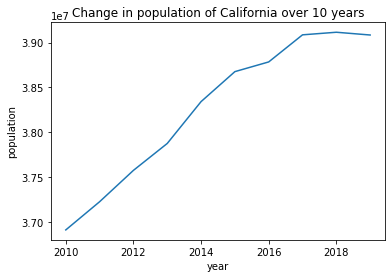

In [27]:
California = US_migration.query("state == 'California'")
sns.lineplot(data=California, x="year", y="population")
plt.title("Change in population of California over 10 years")
plt.show()

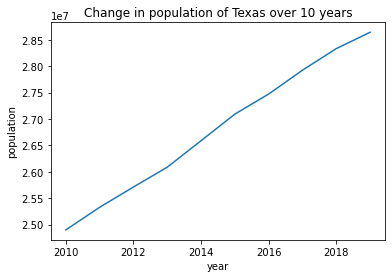

In [28]:
Texas = US_migration.query("state == 'Texas'")
sns.lineplot(data=Texas, x="year", y="population")
plt.title("Change in population of Texas over 10 years")
plt.show()

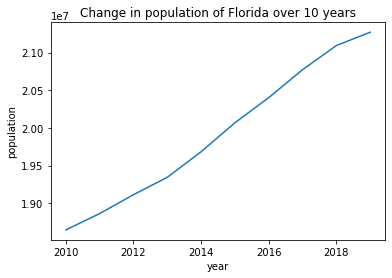

In [29]:
Florida = US_migration.query("state == 'Florida'")
sns.lineplot(data=Florida, x="year", y="population")
plt.title("Change in population of Florida over 10 years")
plt.show()

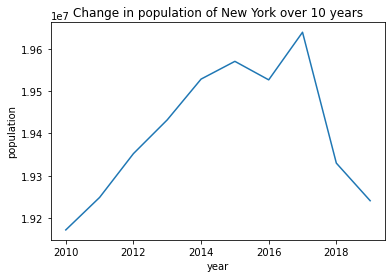

In [30]:
New_york = US_migration.query("state == 'New York'")
sns.lineplot(data = New_york, x="year", y="population")
plt.title("Change in population of New York over 10 years")
plt.show()

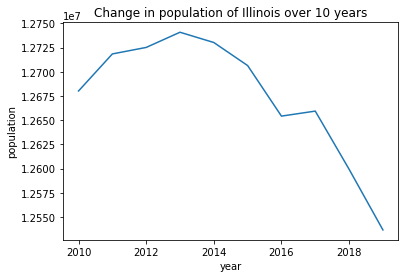

In [31]:
Illinois = US_migration.query("state == 'Illinois'")
sns.lineplot(data = Illinois, x="year", y="population")
plt.title("Change in population of Illinois over 10 years")
plt.show()

Observation: From the above five figures, we are able to see that California, Texas, and Florida all have population strictly increased over the 10 years; New York has a dynamic population change, as it keep increasing until 2015 and starts fluctuate and decrease after 2016; Illinoise has popoulationi increasing at the beginning and it starts to decrease right after 2013. We are wondering if there is some potential relationships between the variables listed and the population change (or migration flow) by the following study in this project.

In other words, the population of California, Texas, and Florida shows an approximate linear relatioship, whereas the population of New York and Illinois shows a Gaussian-like relationship , as they shows a curve concaved downward.

In [32]:
#function to calculate proportion change in population every year
def change_in_pop(l):
    list1=[0]
    for i in range(len(l)-1):
        change=(l[i+1]-l[i])/l[i]
        list1.append(change)
    return list1

# add one more column telling the proportion of the population increased each year  
ratio_change=change_in_pop(US_migration['population'])
US_migration['population_change_proportion']=ratio_change

In [33]:
US_migration.head(10)

,state,year,population,remained,migrate_in,population_change_proportion
0,California,2010,36907897,5413287,444749,0.000000
1,California,2011,37222678,5271168,468428,0.008529
2,California,2012,37572738,5046618,493641,0.009404
3,California,2013,37873189,4898331,485477,0.007997
4,California,2014,38340324,4659084,513968,0.012334
5,California,2015,38675135,4377667,514477,0.008733
6,California,2016,38783436,4337251,514758,0.002800
7,California,2017,39085984,4234770,523131,0.007801
8,California,2018,39114889,4092388,501023,0.000740
9,California,2019,39084048,3943139,480204,-0.000788


# Visualization of dataset2(median household income)

For dataset 2, we will be extracting data from the five states with highest population. We will look at the change in median househome income and change in population from 2010 to 2019 and we will perform a linear regression to determine the relationship between median household income and migration.

Let's first look at the change of median household income from 2010 to 2019 of the whole nation.

Text(0.5, 0, 'Year')

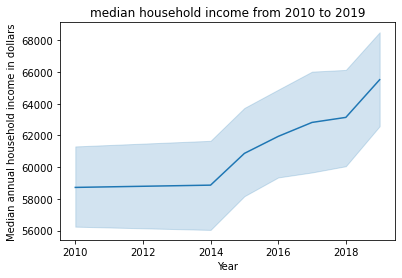

In [34]:
ax=sns.lineplot(x='year', y='median_hhi', data=Household_income)
ax.set_title('median household income from 2010 to 2019')
ax.set_ylabel('Median annual household income in dollars')
ax.set_xlabel('Year')

We can see a trend going upward in the nation from 60000 dollars anually to 65000 dollars.
We then filter the dataset for only the five most populous states and then combine the median household dataset with the migration dataset to look at both variables at the same time.

In [35]:
#filter for 5 states with most population
Household_income=Household_income[(Household_income['state'] == 'California')|(Household_income['state'] == 'Texas')\
                 |(Household_income['state'] == 'New York')|(Household_income['state'] == 'Illinois')\
                |(Household_income['state'] == 'Florida')]
Most_populations=['California','Texas','Florida','New York','Illinois']
Household_income=Household_income.set_index('state').loc[Most_populations].reset_index()

In [36]:
#combine 2 datasets
US_migration_dropped = US_migration[(US_migration['year']!=2011)&(US_migration['year']!=2012)&(US_migration['year']!=2013)].reset_index()
frames = [US_migration_dropped,Household_income]
migration_income = pd.concat(frames,axis=1)
#migration_income = migration_income.T.drop_duplicates().T
#migration_income =migration_income.drop(columns=['index'])

The most populous state is California and we visualize the change in median household income as well as population below.

In [37]:
California_income=Household_income[(Household_income['state'] == 'California')]


Text(0.5, 0, 'Year')

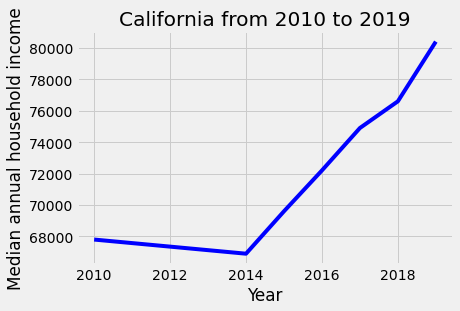

In [38]:
plt.style.use('fivethirtyeight')

ax1=sns.lineplot(x='year', y='median_hhi',data=California_income,color='blue',sort=False,)
ax1.set_title('California from 2010 to 2019')
ax1.set_ylabel('Median annual household income')
ax1.set_xlabel('Year')


Text(0.5, 0, 'Year')

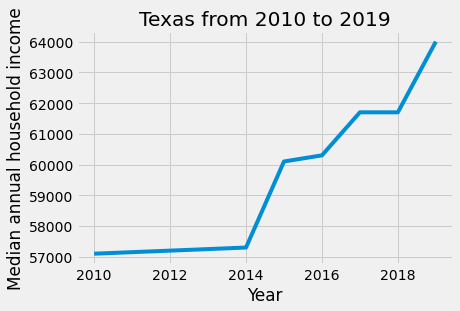

In [39]:
Texas_income=Household_income[(Household_income['state'] == 'Texas')]
plt.style.use('fivethirtyeight')
ax2=sns.lineplot(x='year', y='median_hhi', data=Texas_income)
ax2.set_title('Texas from 2010 to 2019')
ax2.set_ylabel('Median annual household income')
ax2.set_xlabel('Year')

Text(0.5, 0, 'Year')

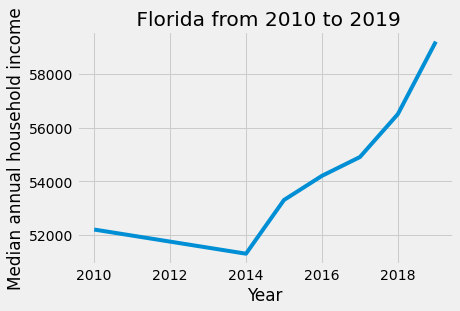

In [40]:
Florida_income=Household_income[(Household_income['state'] == 'Florida')]
plt.style.use('fivethirtyeight')
ax2=sns.lineplot(x='year', y='median_hhi', data=Florida_income)
ax2.set_title(' Florida from 2010 to 2019')
ax2.set_ylabel('Median annual household income')
ax2.set_xlabel('Year')

Text(0.5, 0, 'Year')

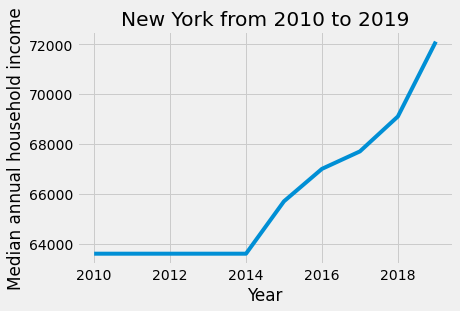

In [41]:
Newyork_income=Household_income[(Household_income['state'] == 'New York')]
plt.style.use('fivethirtyeight')
ax2=sns.lineplot(x='year', y='median_hhi', data=Newyork_income)
ax2.set_title('New York from 2010 to 2019')
ax2.set_ylabel('Median annual household income')
ax2.set_xlabel('Year')

Text(0.5, 0, 'Year')

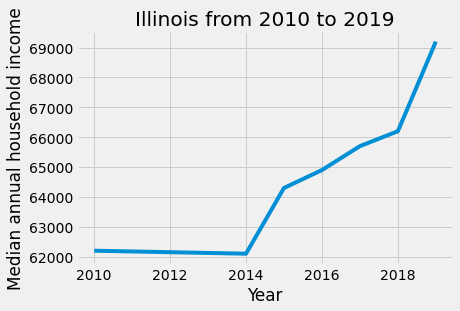

In [42]:
Illinois_income=Household_income[(Household_income['state'] == 'Illinois')]
plt.style.use('fivethirtyeight')
ax2=sns.lineplot(x='year', y='median_hhi', data=Illinois_income)
ax2.set_title('Illinois from 2010 to 2019')
ax2.set_ylabel('Median annual household income')
ax2.set_xlabel('Year')

In the line graph above, we can clearly see all 5 states shows a upward trend in median household income that is consistent with the national trend. Florida and California shows a slight drop from 2010-2014 and all states shows significantly increase in median household income starting from 2014.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Population Change vs. Median Income')

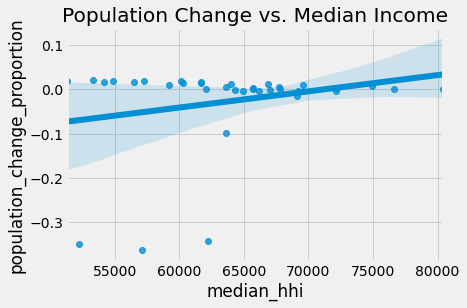

In [43]:
#plot the "change in population proportion" vs "median salary" with a linear regression line
sns.regplot(migration_income['median_hhi'],\
             migration_income['population_change_proportion'])
plt.title("Population Change vs. Median Income")


We can see a few outliers that has a significant negative change in population around -0.3 that alters the slope of the regression line. 

In [44]:
#We perfomred OLS regression results on the relationship of proportion change in population and migration
outcome, predictors = patsy.dmatrices('population_change_proportion ~ median_hhi', migration_income)
model1 = sm.OLS(outcome, predictors)

res_1 = model1.fit()

In [45]:
print(res_1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     population_change_proportion   R-squared:                       0.061
Model:                                      OLS   Adj. R-squared:                  0.033
Method:                           Least Squares   F-statistic:                     2.143
Date:                          Thu, 08 Dec 2022   Prob (F-statistic):              0.153
Time:                                  01:03:14   Log-Likelihood:                 31.671
No. Observations:                            35   AIC:                            -59.34
Df Residuals:                                33   BIC:                            -56.23
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

We get a p value of 0.153 which is higher than 0.05 and showing that there is not significant relationship between the median household income and proportion change in population in those 5 states together. Thus, we fail to prove that median household income could significantly change migration in or out of the 4 states.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'California: Population Change vs. Median Income')

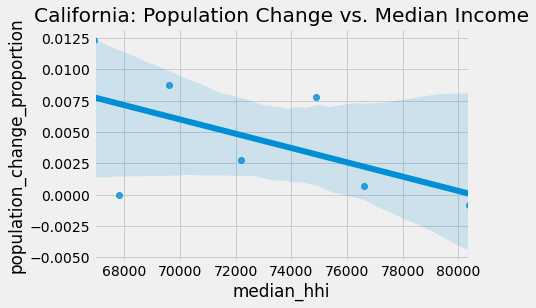

In [46]:
# If we are only looking at California:
sns.regplot(migration_income.head(7)['median_hhi'],\
             migration_income.head(7)['population_change_proportion'])
plt.title("California: Population Change vs. Median Income")

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Illinois: Population Change vs. Median Income')

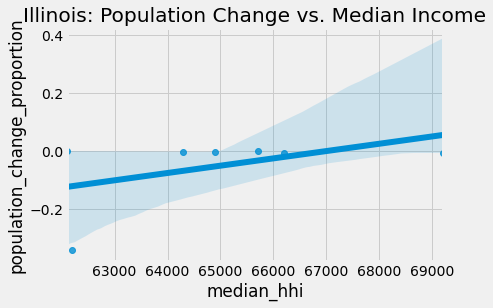

In [47]:
# If we are only looking at Illinois:
sns.regplot(migration_income.tail(7)['median_hhi'],\
             migration_income.tail(7)['population_change_proportion'])
plt.title("Illinois: Population Change vs. Median Income")

So far, are result above has not show any strong relationship between the population change and median income, since the linear regression line is based on several outliers in all the plots above, which make the relationship extremely vague and insignificant. Additionally, notice that when we look at all five state (as the whole), and then one specific state like California or Illinois, we obtained oppsite results shown by the opposite slope of the regression line.

# Visualization of Dataset 3

For dataset 3, we will be extracting data from the five states with highest population as before, and we will perform a linear regression to determine the relationship between GDP and migration.

First, we will take a look at the overall trend of US GDP from 2010 to 2019

In [48]:
#Total US GDP from 2010 to 2019
US_GDP1 = pd.DataFrame()
years = ['2010', '2011', '2012','2013', '2014', '2015', '2016', '2017', '2018', '2019']
US_GDP1['state'] = ['United States'] * 10
US_GDP1['year'] = years
US_sub = US_GDP.loc[US_GDP['GeoName'] == 'United States *']
US_GDPVal = US_sub.loc[0, :][years].values.tolist()
US_GDP1['GDP'] = US_GDPVal
US_GDP1

,state,year,GDP
0,United States,2010,14992052.0
1,United States,2011,15542582.0
2,United States,2012,16197007.0
3,United States,2013,16784851.0
4,United States,2014,17527258.0
5,United States,2015,18238301.0
6,United States,2016,18745075.0
7,United States,2017,19542980.0
8,United States,2018,20611861.0
9,United States,2019,21433226.0


Text(0.5, 0, 'Year')

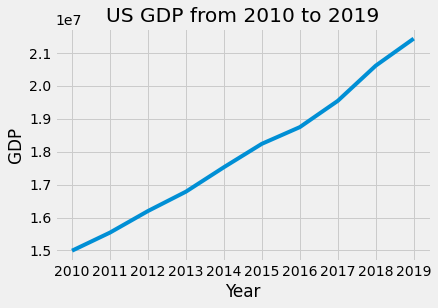

In [49]:
plt.style.use('fivethirtyeight')
f1, ax = plt.subplots()
ax.set_title('US GDP from 2010 to 2019')
ax = sns.lineplot(x='year', y='GDP', data=US_GDP1)
ax.set_xlabel('Year')

Looks like the US GDP has been constantly increasing over these years. This is not surprising, since the US does have one of the strongest economy in the world. Let's take a look at the individual GDP's of different states. 

In [50]:
CA_GDP = pd.DataFrame()
CA_GDP['state'] = ['California'] * 10
CA_GDP['year'] = years
CA_sub = US_GDP.loc[US_GDP['GeoName'] == 'California']
CA_sub = CA_sub.reset_index(drop=True)
CA_GDPVal = CA_sub.loc[0, :][years].values.tolist()
CA_GDP['GDP'] = CA_GDPVal
CA_GDP

,state,year,GDP
0,California,2010,1973511.9
1,California,2011,2049336.8
2,California,2012,2144089.6
3,California,2013,2261510.6
4,California,2014,2399077.7
5,California,2015,2559643.2
6,California,2016,2671100.5
7,California,2017,2831038.4
8,California,2018,2975083.0
9,California,2019,3132800.6


Text(0.5, 0, 'Year')

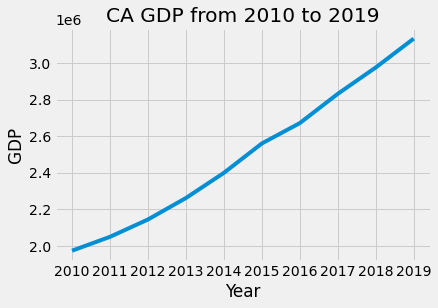

In [51]:
plt.style.use('fivethirtyeight')
f2, ax = plt.subplots()
ax.set_title('CA GDP from 2010 to 2019')
ax = sns.lineplot(x='year', y='GDP', data=CA_GDP)
ax.set_xlabel('Year')

In [52]:
TX_GDP = pd.DataFrame()
TX_GDP['state'] = ['Texas'] * 10
TX_GDP['year'] = years
TX_sub = US_GDP.loc[US_GDP['GeoName'] == 'Texas']
TX_sub = TX_sub.reset_index(drop=True)
TX_GDPVal = TX_sub.loc[0, :][years].values.tolist()
TX_GDP['GDP'] = TX_GDPVal
TX_GDP

,state,year,GDP
0,Texas,2010,1237304.0
1,Texas,2011,1331138.4
2,Texas,2012,1410447.8
3,Texas,2013,1500554.3
4,Texas,2014,1568070.8
5,Texas,2015,1564374.3
6,Texas,2016,1567687.1
7,Texas,2017,1665428.0
8,Texas,2018,1795635.1
9,Texas,2019,1843802.7


Text(0.5, 0, 'Year')

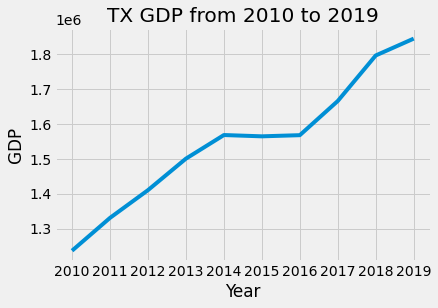

In [53]:
plt.style.use('fivethirtyeight')
f3, ax = plt.subplots()
ax.set_title('TX GDP from 2010 to 2019')
ax = sns.lineplot(x='year', y='GDP', data=TX_GDP)
ax.set_xlabel('Year')

In [54]:
FL_GDP = pd.DataFrame()
FL_GDP['state'] = ['Florida'] * 10
FL_GDP['year'] = years
FL_sub = US_GDP.loc[US_GDP['GeoName'] == 'Florida']
FL_sub = FL_sub.reset_index(drop=True)
FL_GDPVal = FL_sub.loc[0, :][years].values.tolist()
FL_GDP['GDP'] = FL_GDPVal
FL_GDP

,state,year,GDP
0,Florida,2010,738242.3
1,Florida,2011,746535.3
2,Florida,2012,768722.9
3,Florida,2013,800886.0
4,Florida,2014,840386.4
5,Florida,2015,897754.7
6,Florida,2016,941561.2
7,Florida,2017,990096.6
8,Florida,2018,1050298.4
9,Florida,2019,1106500.1


Text(0.5, 0, 'Year')

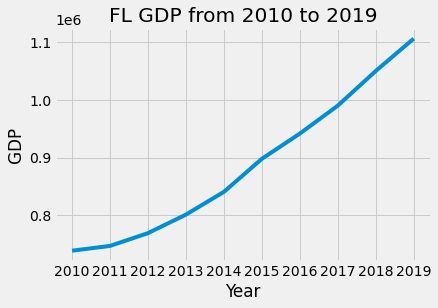

In [55]:
plt.style.use('fivethirtyeight')
f4, ax = plt.subplots()
ax.set_title('FL GDP from 2010 to 2019')
ax = sns.lineplot(x='year', y='GDP', data=FL_GDP)
ax.set_xlabel('Year')

In [56]:
NY_GDP = pd.DataFrame()
NY_GDP['state'] = ['New York'] * 10
NY_GDP['year'] = years
NY_sub = US_GDP.loc[US_GDP['GeoName'] == 'New York']
NY_sub = NY_sub.reset_index(drop=True)
NY_GDPVal = NY_sub.loc[0, :][years].values.tolist()
NY_GDP['GDP'] = NY_GDPVal
NY_GDP

,state,year,GDP
0,New York,2010,1212485.1
1,New York,2011,1237277.6
2,New York,2012,1323400.8
3,New York,2013,1361962.9
4,New York,2014,1425724.1
5,New York,2015,1485620.8
6,New York,2016,1545987.7
7,New York,2017,1608890.2
8,New York,2018,1705010.2
9,New York,2019,1772260.7


Text(0.5, 0, 'Year')

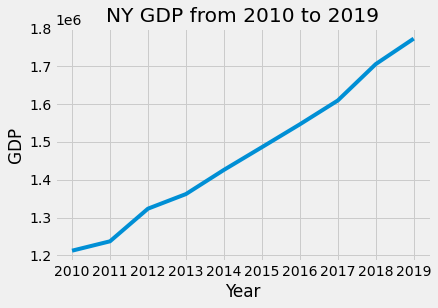

In [57]:
plt.style.use('fivethirtyeight')
f5, ax = plt.subplots()
ax = sns.lineplot(x='year', y='GDP', data=NY_GDP)
ax.set_title('NY GDP from 2010 to 2019')
ax.set_xlabel('Year')

In [58]:
IL_GDP = pd.DataFrame()
IL_GDP['state'] = ['Illinois'] * 10
IL_GDP['year'] = years
IL_sub = US_GDP.loc[US_GDP['GeoName'] == 'Illinois']
IL_sub = IL_sub.reset_index(drop=True)
IL_GDPVal = IL_sub.loc[0, :][years].values.tolist()
IL_GDP['GDP'] = IL_GDPVal
IL_GDP

,state,year,GDP
0,Illinois,2010,661714.8
1,Illinois,2011,687951.0
2,Illinois,2012,720881.5
3,Illinois,2013,734808.5
4,Illinois,2014,766120.8
5,Illinois,2015,795326.1
6,Illinois,2016,803943.7
7,Illinois,2017,823776.2
8,Illinois,2018,863039.5
9,Illinois,2019,885583.0


Text(0.5, 0, 'Year')

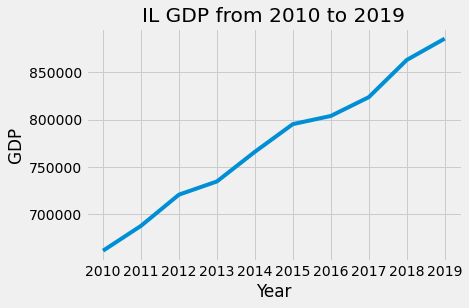

In [59]:
plt.style.use('fivethirtyeight')
f6, ax = plt.subplots()
ax.set_title('IL GDP from 2010 to 2019')
ax = sns.lineplot(x='year', y='GDP', data=IL_GDP)
ax.set_xlabel('Year')

Interestingly, other than a small economic recession in Texas from approximately 2014 to 2016, almost all these states with high population as well as migration rates show a steady growth in GDP. This might suggest a possible correlation between GDP and migration rates.

To further analyze our data, we will combine these GDP values into a larger table and merge with the dataset US_migration that was previously created.

In [60]:
# Combining data
frames = [CA_GDP, TX_GDP, FL_GDP, NY_GDP, IL_GDP]
Total_GDP = pd.concat(frames)
Total_GDP.reset_index(drop=True)

,state,year,GDP
0,California,2010,1973511.9
1,California,2011,2049336.8
2,California,2012,2144089.6
3,California,2013,2261510.6
4,California,2014,2399077.7
5,California,2015,2559643.2
6,California,2016,2671100.5
7,California,2017,2831038.4
8,California,2018,2975083.0
9,California,2019,3132800.6


In [61]:
# Merging data
US_migration['GDP'] = Total_GDP['GDP'].values.tolist()
US_migration

,state,year,population,remained,migrate_in,population_change_proportion,GDP
0,California,2010,36907897,5413287,444749,0.000000,1973511.9
1,California,2011,37222678,5271168,468428,0.008529,2049336.8
2,California,2012,37572738,5046618,493641,0.009404,2144089.6
3,California,2013,37873189,4898331,485477,0.007997,2261510.6
4,California,2014,38340324,4659084,513968,0.012334,2399077.7
5,California,2015,38675135,4377667,514477,0.008733,2559643.2
6,California,2016,38783436,4337251,514758,0.002800,2671100.5
7,California,2017,39085984,4234770,523131,0.007801,2831038.4
8,California,2018,39114889,4092388,501023,0.000740,2975083.0
9,California,2019,39084048,3943139,480204,-0.000788,3132800.6


Now that the data is all set, we will first take a look at the scatterplot that demonstrates how GDP and population change(migration rate) can possibly interact with each other

Text(0, 0.5, 'Proportion of Population Change')

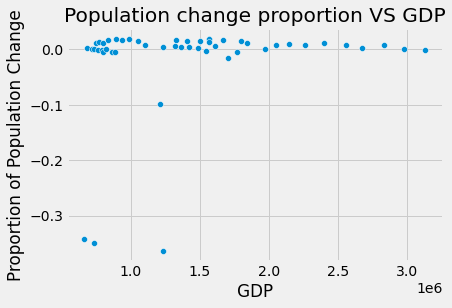

In [62]:
f7, ax = plt.subplots()
ax.set_title('Population change proportion VS GDP')
ax = sns.scatterplot(x='GDP', y='population_change_proportion', data=US_migration)
ax.set_ylabel('Proportion of Population Change')

It seems like there are several outliers that are at the bottom of the spectrum. In order to reduce the effect of outliers in the data, we will do a log transformation for change in proportion of population.

In [63]:
US_migration['population_change_proportion_log10'] = np.log10(US_migration['population_change_proportion'] + 0.1)
US_migration.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,state,year,population,remained,migrate_in,population_change_proportion,GDP,population_change_proportion_log10
0,California,2010,36907897,5413287,444749,0.000000,1973511.9,-1.000000
1,California,2011,37222678,5271168,468428,0.008529,2049336.8,-0.964455
2,California,2012,37572738,5046618,493641,0.009404,2144089.6,-0.960965
3,California,2013,37873189,4898331,485477,0.007997,2261510.6,-0.966590
4,California,2014,38340324,4659084,513968,0.012334,2399077.7,-0.949488


Now we will try to look at the scatterplot again

Text(0, 0.5, 'Proportion of Population Change')

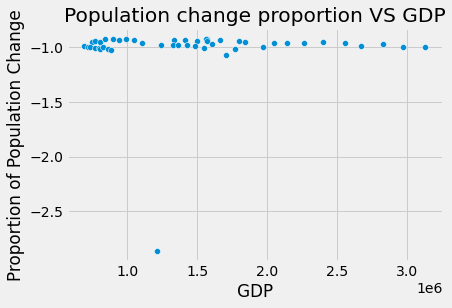

In [64]:
f8, ax = plt.subplots()
ax.set_title('Population change proportion VS GDP')
ax = sns.scatterplot(x='GDP', y='population_change_proportion_log10', data=US_migration)
ax.set_ylabel('Proportion of Population Change')

There is still one outlier left, so we will have to delete it from our dataset.

In [65]:
#Check location of outlier
US_migration.loc[US_migration['population_change_proportion_log10'] < -2.5]

,state,year,population,remained,migrate_in,population_change_proportion,GDP,population_change_proportion_log10
30,New York,2010,19171916,1779540,269427,-0.098615,1212485.1,-2.858701


In [66]:
US_migration = US_migration.drop([30])
US_migration

,state,year,population,remained,migrate_in,population_change_proportion,GDP,population_change_proportion_log10
0,California,2010,36907897,5413287,444749,0.000000,1973511.9,-1.000000
1,California,2011,37222678,5271168,468428,0.008529,2049336.8,-0.964455
2,California,2012,37572738,5046618,493641,0.009404,2144089.6,-0.960965
3,California,2013,37873189,4898331,485477,0.007997,2261510.6,-0.966590
4,California,2014,38340324,4659084,513968,0.012334,2399077.7,-0.949488
5,California,2015,38675135,4377667,514477,0.008733,2559643.2,-0.963640
6,California,2016,38783436,4337251,514758,0.002800,2671100.5,-0.988006
7,California,2017,39085984,4234770,523131,0.007801,2831038.4,-0.967377
8,California,2018,39114889,4092388,501023,0.000740,2975083.0,-0.996800
9,California,2019,39084048,3943139,480204,-0.000788,3132800.6,-1.003438


Once again, we will look at the scatterplot:

Text(0, 0.5, 'Proportion of Population Change')

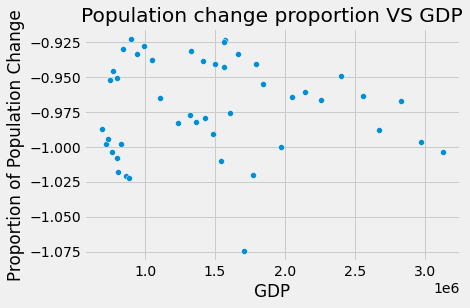

In [83]:
f9, ax = plt.subplots()
ax.set_title('Population change proportion VS GDP')
ax = sns.scatterplot(x='GDP', y='population_change_proportion_log10', data=US_migration)
ax.set_ylabel('Proportion of Population Change')

Now our scatterplot represents more the relationship between GDP and population change(migration rate). However, we can't identify an obvious relationship between these two variables just by looking at them. Therefore, we must perform a linear regression to test our hypothesis.

In [68]:
outcome, predictors = patsy.dmatrices('population_change_proportion_log10 ~ GDP', US_migration)
model2 = sm.OLS(outcome, predictors)

res_2 = model2.fit()

In [69]:
print(res_2.summary())

                                    OLS Regression Results                                    
Dep. Variable:     population_change_proportion_log10   R-squared:                       0.001
Model:                                            OLS   Adj. R-squared:                 -0.021
Method:                                 Least Squares   F-statistic:                   0.06154
Date:                                Thu, 08 Dec 2022   Prob (F-statistic):              0.805
Time:                                        01:03:15   Log-Likelihood:                 90.722
No. Observations:                                  46   AIC:                            -177.4
Df Residuals:                                      44   BIC:                            -173.8
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
                 coef    std err          t      P

Surprisingly, we can see that there is a very low correlation between interstate migration rates and state GDP  from the regression results. The value of R-square is 0.001, which indicates that only 0.001% of the data can be accounted for by this linear model. More over, the P-value for GDP is 0.805, which means that there is a 0.805 of obtaining these results assuming that the null hypothesis is true. There are several possible explanations for this relationship. First, even though GDP is widely used as a standard of living, it might not be the best measure for standard of living due to the rapidly increasing wealth gap. In 2020, income at the top of the income distribution was already 13.53 times higher than income at the bottom as reported by the U.S. Census Bureau(https://www.census.gov/). Second. while interstate migration is fairly common, a higher GDP could be more likely to attract international immigrants instead of interstate migrants, which could possibly serve us as a false impression that interstate migrants are also more likely to move to states with a higher GDP. Third and lastly, even though standard of living is an important factor to consider during migration, the standard of living might not be the primary factor that causes people to migrate. These are only possible explanations that explains the no correlation between GDP and migration rate, and further studies need to be conducted to gain further evidence.

# Visualization of data 4

In the process of exploratory data analysis, we will be exploring the relationships between variables of the our datasets and identify trends based on our graphs generated below. 

Second, we will examine the relationship between 

In [70]:
df_Cali = pd.read_csv("California")
df_Cali.rename({'CASTHPI': 'Price_Index'}, axis=1, inplace=True)
df_2010_2019_Cali = df_Cali[140:180]
df_2010_2019_Cali.head()

,DATE,Price_Index
140,2010-01-01,409.86
141,2010-04-01,408.66
142,2010-07-01,410.90
143,2010-10-01,406.37
144,2011-01-01,391.87


In [71]:
## YOUR CODE HERE
def standardize_date(string):
    
    string = string.lower()
    string = string.strip()
    
    if '2010' in string:
        output = '2010'
    elif '2011' in string:
        output = '2011'
    elif '2012' in string:
        output = '2012'
    elif '2013' in string:
        output = '2013'
    elif '2014' in string:
        output = '2014'
    elif '2015' in string:
        output = '2015'
    elif '2016' in string:
        output = '2016'
    elif '2017' in string:
        output = '2017'
    elif '2018' in string:
        output = '2018'
    elif '2019' in string:
        output = '2019'
    
    return output

/tmp/ipykernel_494/2590893840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_2019_Cali['DATE'] = df_2010_2019_Cali['DATE'].apply(standardize_date)


<AxesSubplot:xlabel='DATE', ylabel='Price_Index'>

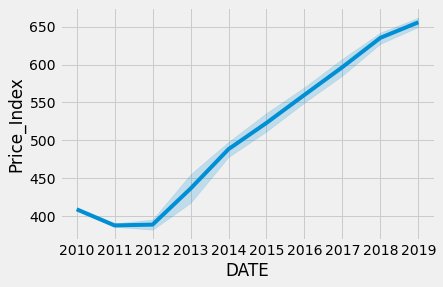

In [72]:
df_2010_2019_Cali['DATE'] = df_2010_2019_Cali['DATE'].apply(standardize_date)
df_2010_2019_Cali.groupby('DATE').mean()

df_2010_2019_Cali.reset_index()

sns.lineplot(data=df_2010_2019_Cali,x= 'DATE',y='Price_Index')


In [73]:
df_Texas = pd.read_csv("Texas")
##df_Cali.rename({'CASTHPI': 'Price_Index'}, axis=1, inplace=True)
df_2010_2019_Texas = df_Texas[140:180]
df_2010_2019_Texas.head()

,DATE,Price_Index
140,2010-01-01,221.62
141,2010-04-01,221.78
142,2010-07-01,223.16
143,2010-10-01,222.20
144,2011-01-01,218.94


/tmp/ipykernel_494/3824497256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_2019_Texas['DATE'] = df_2010_2019_Texas['DATE'].apply(standardize_date)


<AxesSubplot:xlabel='DATE', ylabel='Price_Index'>

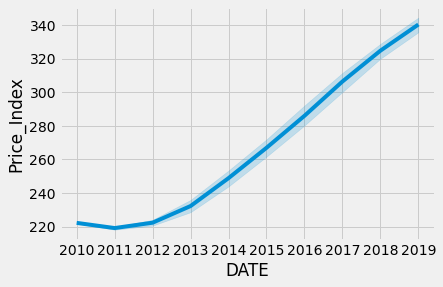

In [74]:
df_2010_2019_Texas['DATE'] = df_2010_2019_Texas['DATE'].apply(standardize_date)
df_2010_2019_Texas.groupby('DATE').mean()

df_2010_2019_Texas.reset_index()

sns.lineplot(data=df_2010_2019_Texas,x= 'DATE',y='Price_Index')


In [75]:
df_Florida = pd.read_csv("Florida")
##df_Cali.rename({'CASTHPI': 'Price_Index'}, axis=1, inplace=True)
df_2010_2019_Florida = df_Florida[140:180]
df_2010_2019_Florida.head()

,DATE,Price_Index
140,2010-01-01,299.76
141,2010-04-01,291.43
142,2010-07-01,294.87
143,2010-10-01,289.55
144,2011-01-01,275.75


/tmp/ipykernel_494/3484576513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_2019_Florida['DATE'] = df_2010_2019_Florida['DATE'].apply(standardize_date)


<AxesSubplot:xlabel='DATE', ylabel='Price_Index'>

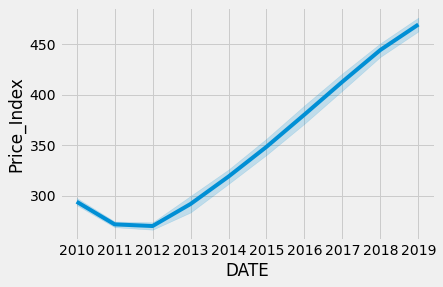

In [76]:
df_2010_2019_Florida['DATE'] = df_2010_2019_Florida['DATE'].apply(standardize_date)
df_2010_2019_Florida.groupby('DATE').mean()

df_2010_2019_Florida.reset_index()

sns.lineplot(data=df_2010_2019_Florida,x= 'DATE',y='Price_Index')


/tmp/ipykernel_494/922764983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_2019_New_York['DATE'] = df_2010_2019_New_York['DATE'].apply(standardize_date)


<AxesSubplot:xlabel='DATE', ylabel='Price_Index'>

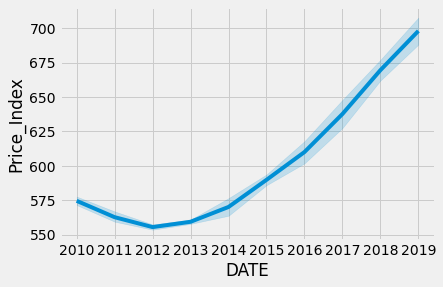

In [77]:
df_New_York = pd.read_csv("New_York")

df_2010_2019_New_York = df_New_York[140:180]
df_2010_2019_New_York

df_2010_2019_New_York['DATE'] = df_2010_2019_New_York['DATE'].apply(standardize_date)
df_2010_2019_New_York.groupby('DATE').mean()

df_2010_2019_New_York.reset_index()

sns.lineplot(data=df_2010_2019_New_York,x= 'DATE',y='Price_Index')

/tmp/ipykernel_494/3258092009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_2019_Illinois['DATE'] = df_2010_2019_Illinois['DATE'].apply(standardize_date)


<AxesSubplot:xlabel='DATE', ylabel='Price_Index'>

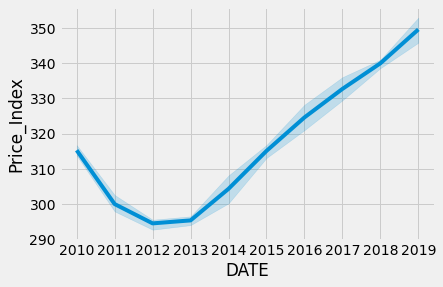

In [78]:
df_Illinois = pd.read_csv("Illinois")

df_2010_2019_Illinois = df_Illinois[140:180]
df_2010_2019_Illinois

df_2010_2019_Illinois['DATE'] = df_2010_2019_Illinois['DATE'].apply(standardize_date)
df_2010_2019_Illinois.groupby('DATE').mean()

df_2010_2019_Illinois.reset_index()

sns.lineplot(data=df_2010_2019_Illinois,x= 'DATE',y='Price_Index')

The price-index (representing the level of housing price) for each state shows similar a trend overtime: decreasing from the begining and starts to increase in roughly 2012, and continuous increasing afterwards, thus they shows a concaved-up plot, which is not neccessarily linear. Now,let's take a look if there is a possible correlation between the migration flow and the price-index.

In [79]:
# let's take a look at California:

In [80]:
cali_index_2010 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2010']['Price_Index'].mean()
cali_index_2011 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2011']['Price_Index'].mean()
cali_index_2012 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2012']['Price_Index'].mean()
cali_index_2013 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2013']['Price_Index'].mean()
cali_index_2014 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2014']['Price_Index'].mean()
cali_index_2015 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2015']['Price_Index'].mean()
cali_index_2016 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2016']['Price_Index'].mean()
cali_index_2017 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2017']['Price_Index'].mean()
cali_index_2018 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2018']['Price_Index'].mean()
cali_index_2019 = df_2010_2019_Cali[df_2010_2019_Cali['DATE']=='2019']['Price_Index'].mean()
Cali_index = [cali_index_2010, cali_index_2011, cali_index_2012, cali_index_2013, cali_index_2014, \
              cali_index_2015, cali_index_2016, cali_index_2017, cali_index_2018, cali_index_2019]

In [81]:
Cali_pop = US_migration.head(10)['population']

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'California Population vs. Price-Index-Housing')

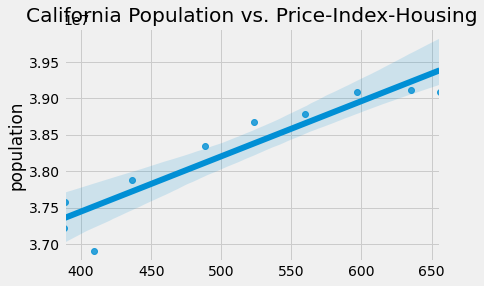

In [82]:
sns.regplot(Cali_index, Cali_pop)
plt.title("California Population vs. Price-Index-Housing")

By looking at the populatio trend of California in 2010-2019, we notice that there is no obvious correlation between the population and price-index. The one outlier in the graph above is very obvious, that lies very far away from our regression line. Thus the linear regression leads to no significant correlation.